# Introduction to SummarizedExperiment and RESTful interface

The code reviewed here should run in either R 3.5 or R 3.6.  Some details of
execution may differ between the two R versions.

## Concepts

- Genomic data is an amalgam of numerical quantifications and metadata about assay features and experimental samples
- SummarizedExperiment unifies relevant information and reduces risks of mismatching data elements of disparate types 
    - let X denote a SummarizedExperiment instance
    - Let G denote a vector of feature identifiers, and S denote a vector of sample identifiers
-   X[G, S] is a SummarizedExperiment with features restricted to those in G, and samples restricted to those in S

## Some code for the in-memory approach

We'll look at a time-course experiment in yeast to fix ideas.  First we'll get the necessary packages.  We
are interested in a package called "fission".  We use BiocManager to get it and any necessary dependencies.

### Installation and attachment

In [41]:
ii = installed.packages()
pks = ii[,"Package"]
if (!("BiocManager" %in% pks)) install.packages("BiocManager")
if (!("fission" %in% pks)) BiocManager::install("fission", ask=FALSE, update=FALSE)

Now we attach the package and load up the dataset of interest.

In [42]:
library(fission)
data(fission)
fission

class: RangedSummarizedExperiment 
dim: 7039 36 
metadata(1): ''
assays(1): counts
rownames(7039): SPAC212.11 SPAC212.09c ... SPMITTRNAGLU.01 SPMIT.11
rowData names(2): symbol biotype
colnames(36): GSM1368273 GSM1368274 ... GSM1368307 GSM1368308
colData names(4): strain minute replicate id

### Queries via bracket and assay

Above we have a little report on the contents of "fission" in our R session.  This is a
RangedSummarizedExperiment, that has all the features of a SummarizedExperiment, and a little
more, that we will not go into now.  We can work with it as we would an ordinary matrix.  Here
we query for the first three features and first five samples.

In [43]:
fission[1:3, 1:5]

class: RangedSummarizedExperiment 
dim: 3 5 
metadata(1): ''
assays(1): counts
rownames(3): SPAC212.11 SPAC212.09c SPNCRNA.70
rowData names(2): symbol biotype
colnames(5): GSM1368273 GSM1368274 GSM1368275 GSM1368276 GSM1368277
colData names(4): strain minute replicate id

Note that the 'dim:' report changes.  This is called endomorphism under selection with bracket -- we get a new
SummarizedExperiment limited according to the selection request.

We are interested in the quantifications reported for the selection:

In [44]:
assay(fission[1:3, 1:5])

,GSM1368273,GSM1368274,GSM1368275,GSM1368276,GSM1368277
SPAC212.11,8,4,25,19,10
SPAC212.09c,23,31,49,39,33
SPNCRNA.70,0,0,0,0,0


### Working with metadata

Features are labeled using the "rownames" of the SummarizedExperiment.  Samples are labeled using
GEO identifiers, in the "colnames".  In this case the rownames are not readily interpretable, but
an additional metadata component called rowData is available.

In [45]:
rowData(fission)

DataFrame with 7039 rows and 2 columns
                         symbol        biotype
                    <character>       <factor>
SPAC212.11                 tlh1 protein_coding
SPAC212.09c         SPAC212.09c     pseudogene
SPNCRNA.70           SPNCRNA.70          ncRNA
SPAC212.12           SPAC212.12 protein_coding
SPAC212.04c         SPAC212.04c protein_coding
...                         ...            ...
SPMITTRNATYR.01 SPMITTRNATYR.01           tRNA
SPMITTRNAILE.02 SPMITTRNAILE.02           tRNA
SPMIT.10                   atp9 protein_coding
SPMITTRNAGLU.01 SPMITTRNAGLU.01           tRNA
SPMIT.11                   cox2 protein_coding

To help with symbolic interrogation of the data, we will revise the rownames.  Now
we can get quantifications for genes identified by their common names.

In [46]:
rownames(fission) = rowData(fission)$symbol
assay(fission["mcm5", 1:5])

,GSM1368273,GSM1368274,GSM1368275,GSM1368276,GSM1368277
mcm5,710,301,494,493,247


The colData component of the SummarizedExperiment gives metadata about the features.

In [47]:
head(colData(fission))

DataFrame with 6 rows and 4 columns
             strain   minute replicate          id
           <factor> <factor>  <factor> <character>
GSM1368273       wt        0        r1     wt_0_r1
GSM1368274       wt        0        r2     wt_0_r2
GSM1368275       wt        0        r3     wt_0_r3
GSM1368276       wt       15        r1    wt_15_r1
GSM1368277       wt       15        r2    wt_15_r2
GSM1368278       wt       15        r3    wt_15_r3

We can use the $ shortcut to get values from the colData table.  Here we see
that the data are a combination of mutant and wild type strains.

In [48]:
table(fission$strain)


 wt mut 
 18  18 

### Quick visualization of distributions over time

We can use the bracket notation to visualize aspects of expression variation over time.  We'll create
two series of boxplots, one for WT samples, one for mutants.

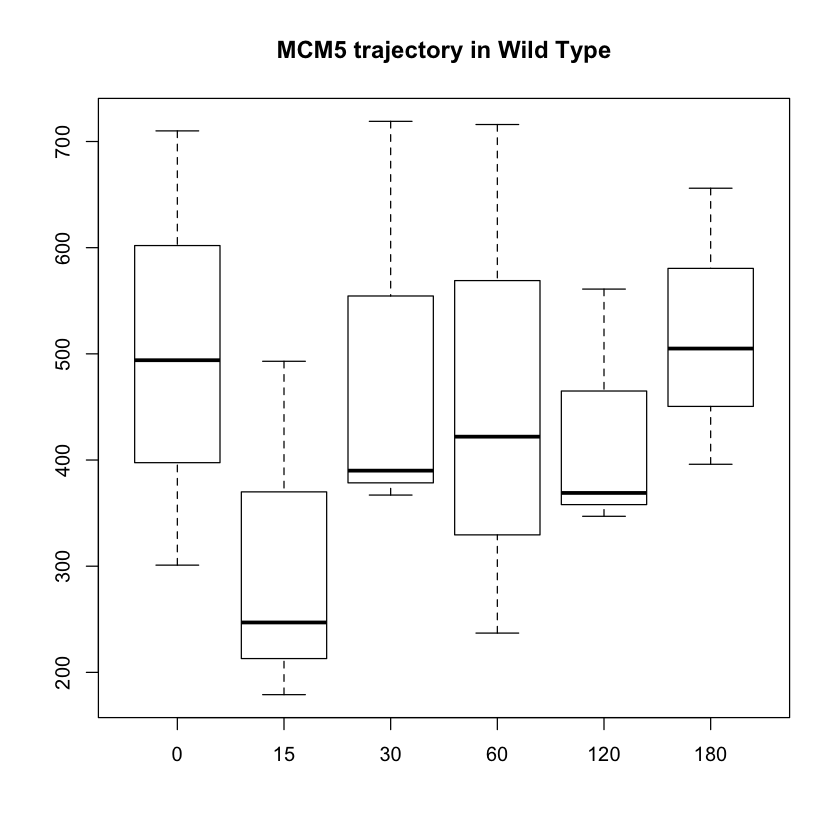

In [49]:
boxplot(split(assay(fission["mcm5", fission$strain=="wt"]), fission$minute[fission$strain=="wt"]), main="MCM5 trajectory in Wild Type")

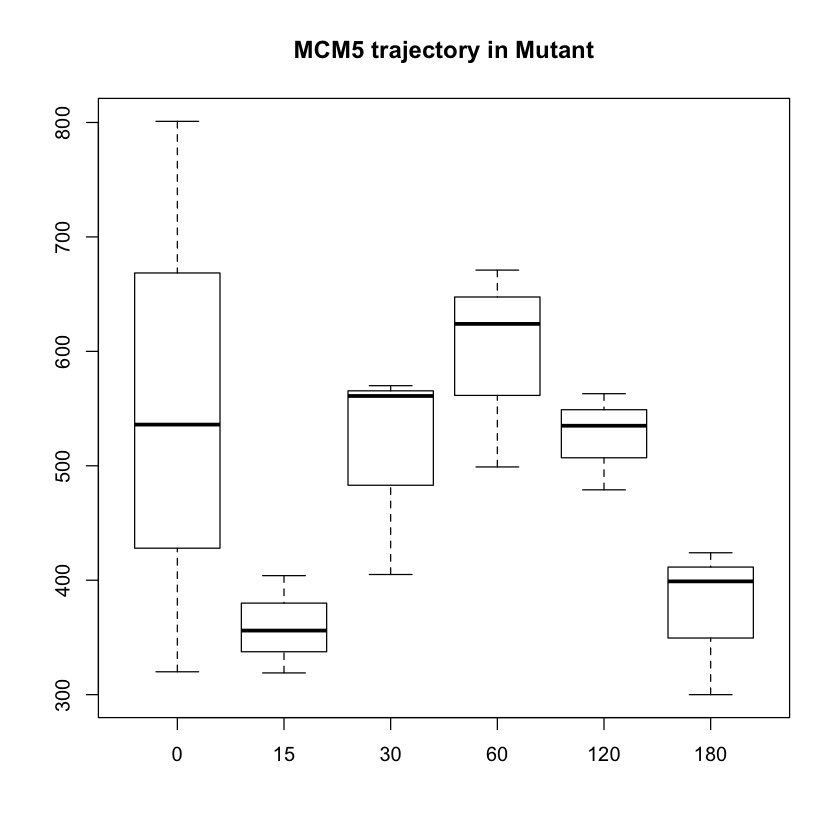

In [50]:
boxplot(split(assay(fission["mcm5", fission$strain=="mut"]), fission$minute[fission$strain=="mut"]), main="MCM5 trajectory in Mutant")

### Summary of the in-memory SummarizedExperiment example

We have shown how the SummarizedExperiment class unifies data of disparate types: assay data (typically in a RAM-resident matrix), feature data (rownames and rowData components), sample data (in a RAM-resident DataFrame instance).

The assay method and the bracket and dollar sign operators are used to reliably and concisely express
queries and perform retrievals in ways that are familiar to almost all users of R.

## The RESTful interface, authentication-free

We can use a cloud-resident data API (HDF Scalable Data Service) for really large data.  We have
to install an additional package.



In [51]:
if (!("restfulSE" %in% pks)) BiocManager::install("restfulSE", ask=FALSE, update=FALSE)
library(restfulSE)

A famous demonstration dataset for single-cell RNA-seq is the 10x genomics 1.3 million neuron dataset.  We can acquire a reference to the annotated quantifications using a function call.

In [52]:
mubr = se1.3M()

snapshotDate(): 2019-01-25
see ?restfulSEData and browseVignettes('restfulSEData') for documentation
downloading 0 resources
loading from cache 
    '/Users/stvjc//.ExperimentHub/1656'


In [53]:
mubr

class: SummarizedExperiment 
dim: 27998 1306127 
metadata(0):
assays(1): counts
rownames(27998): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000096730 ENSMUSG00000095742
rowData names(12): ensid seqnames ... symbol entrezid
colnames(1306127): AAACCTGAGATAGGAG-1 AAACCTGAGCGGCTTC-1 ...
  TTTGTCAGTTAAAGTG-133 TTTGTCATCTGAAAGA-133
colData names(4): Barcode Sequence Library Mouse

In general no one wants to load such a large object into memory, but having a holistic representation of it is attractive.  In this case, we have a DelayedArray interface to the numerical data.  Use of the assay
method gives us a preview of what's in the back end.

In [54]:
assay(mubr)

<27998 x 1306127> DelayedMatrix object of type "double":
                     AAACCTGAGATAGGAG-1 ... TTTGTCATCTGAAAGA-133
ENSMUSG00000051951                    0   .                    0
ENSMUSG00000089699                    0   .                    0
ENSMUSG00000102343                    0   .                    0
ENSMUSG00000025900                    0   .                    0
ENSMUSG00000109048                    0   .                    0
               ...                    .   .                    .
ENSMUSG00000079808                    0   .                    0
ENSMUSG00000095041                    1   .                    0
ENSMUSG00000063897                    0   .                    0
ENSMUSG00000096730                    0   .                    0
ENSMUSG00000095742                    0   .                    0

Under the hood, a REST query to the HSDS API was constructed to get the values for the "corners" of the underlying matrix.  An informal validation of the interface is

In [55]:
apply(as.matrix(assay(mubr[,1:5])), 2, sum)

AAACCTGAGATAGGAG-1 AAACCTGAGCGGCTTC-1 AAACCTGAGGAATCGC-1 AAACCTGAGGACACCA-1 
              4046               2087               4654               3193 
AAACCTGAGGCCCGTT-1 
              8444

These column sums are known to be correct.  In the following, we plot the distributions of two high-expressing genes, confining attention to the "first" 5000 cells in the experiment.  We use a helper function 'ana' to convert
the DelayedArray content to numerical data for analysis.

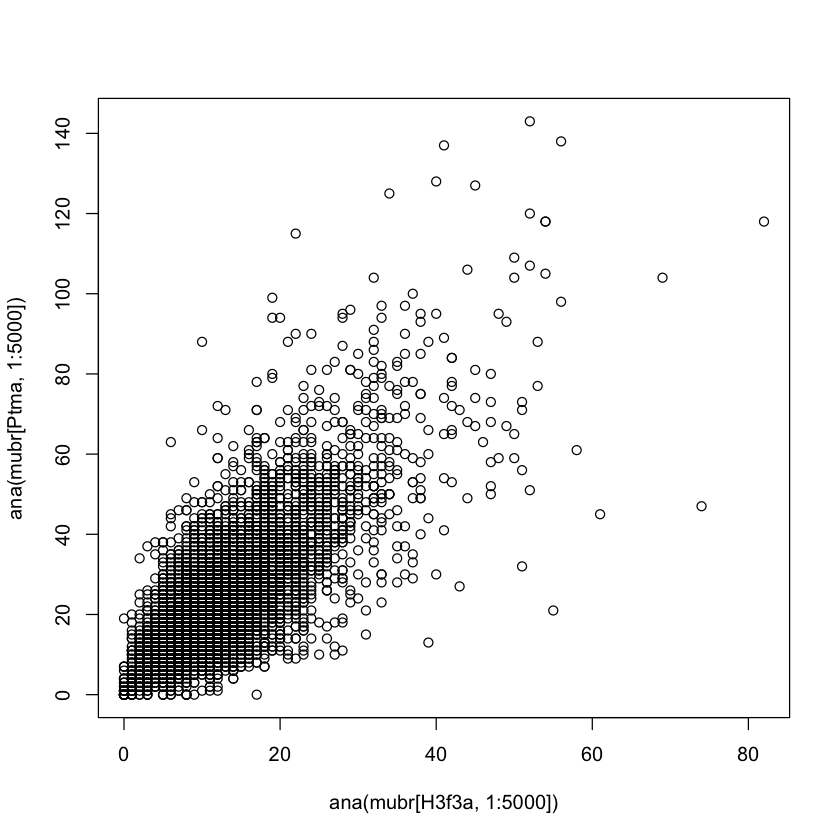

In [56]:
H3f3a = which(rowData(mubr)$symbol == "H3f3a")
Ptma = which(rowData(mubr)$symbol == "Ptma")
ana = function(x) as.numeric(assay(x))
plot(ana(mubr[H3f3a, 1:5000]), ana(mubr[Ptma, 1:5000]))

## The RESTful interface to BigQuery

We have defined tools to work with BigQuery through the SummarizedExperiment interface.  The
best example available concerns working with the PanCancer Atlas data.  To work with this you
will need a valid, billable Google Compute Platform project identification.  When you attempt
your first operation, authentication will be attempted, using OAuth 2.0 protocol.  A persistent token will be added to the current folder to reduce need to reauthenticate.  This is all part of the httr package protocol.  There
may be better approaches that I don't know about yet.

In [57]:
if (!("BiocOncoTK" %in% pks)) BiocManager::install("BiocOncoTK", ask=FALSE, update=FALSE)
if (!("bigrquery" %in% pks)) BiocManager::install("bigrquery", ask=FALSE, update=FALSE)
library(BiocOncoTK)

To get rolling, establish a connection and query available tables.  Replace the billing= setting
with one that is valid for you.

In [58]:
bq = pancan_BQ(billing="vince1-168719")
library(bigrquery)
dbListTables(bq)

[1] "EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_annot"                                       
 [2] "Purity_Ploidy_All_Samples_annot"                                                             
 [3] "TCGA_CDR"                                                                                    
 [4] "TCGA_RPPA_pancan_clean_annot"                                                                
 [5] "clinical_PANCAN_patient_with_followup"                                                       
 [6] "jhu_usc_edu_PANCAN_HumanMethylation27_betaValue_whitelisted_annot"                           
 [7] "jhu_usc_edu_PANCAN_HumanMethylation450_betaValue_whitelisted_annot"                          
 [8] "jhu_usc_edu_PANCAN_merged_HumanMethylation27_HumanMethylation450_betaValue_whitelisted_annot"
 [9] "mc3_v0_2_8_PUBLIC_maf"                                                                       
[10] "merged_sample_quality_annotations_annot"                                                     
[11] "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16_annot"

Once you have gotten a character vector of table names with the command above, you can create a
RESTful SummarizedExperiment as follows:

In [59]:
BLCArna = buildPancanSE(bq, acronym="BLCA", assay="RNASeqv2")
BLCArna

class: SummarizedExperiment 
dim: 20531 408 
metadata(3): acronym assay sampType
assays(1): assay
rownames(20531): 1 10 ... 9994 9997
rowData names(0):
colnames(408): TCGA-FD-A3SN TCGA-FD-A5BV ... TCGA-UY-A78L TCGA-ZF-AA4T
colData names(20): bcr_patient_uuid bcr_patient_barcode ...
  radiation_therapy race

Here the rownames are ENTREZ identifiers; we can replace them by gene symbols.

In [60]:
BLCArnan = replaceRownames(BLCArna)
BLCArnan

121 rows unmapped to ENTREZ, dropped
'select()' returned 1:1 mapping between keys and columns


class: SummarizedExperiment 
dim: 20410 408 
metadata(3): acronym assay sampType
assays(1): assay
rownames(20410): A1BG NAT2 ... CASP8AP2 SCO2
rowData names(0):
colnames(408): TCGA-FD-A3SN TCGA-FD-A5BV ... TCGA-UY-A78L TCGA-ZF-AA4T
colData names(20): bcr_patient_uuid bcr_patient_barcode ...
  radiation_therapy race

The colData is a small selection from the hundreds of clinical variables that are available in the atlas.
The actual variables are:

In [61]:
names(colData(BLCArnan))

[1] "bcr_patient_uuid"                         
 [2] "bcr_patient_barcode"                      
 [3] "acronym"                                  
 [4] "gender"                                   
 [5] "vital_status"                             
 [6] "days_to_birth"                            
 [7] "days_to_death"                            
 [8] "days_to_last_followup"                    
 [9] "days_to_initial_pathologic_diagnosis"     
[10] "age_at_initial_pathologic_diagnosis"      
[11] "icd_10"                                   
[12] "tissue_retrospective_collection_indicator"
[13] "icd_o_3_histology"                        
[14] "tissue_prospective_collection_indicator"  
[15] "history_of_neoadjuvant_treatment"         
[16] "icd_o_3_site"                             
[17] "tumor_tissue_site"                        
[18] "new_tumor_event_after_initial_treatment"  
[19] "radiation_therapy"                        
[20] "race"

In [62]:
summary(BLCArnan$age_at_initial_pathologic_diagnosis)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34.00   60.00   69.00   68.08   76.00   90.00 

In [63]:
table(BLCArnan$icd_10)


C67.0 C67.1 C67.2 C67.3 C67.4 C67.5 C67.6 C67.9 
   24    14    63    20    50     1     1   235 

The ICD10 codes correspond to anatomic details of tumor location.  67.9 is unspecified.

Exploration of the data can proceed in various directions.  In the following, we make
boxplots for the distribution of FGFR3 across strata defined by age.

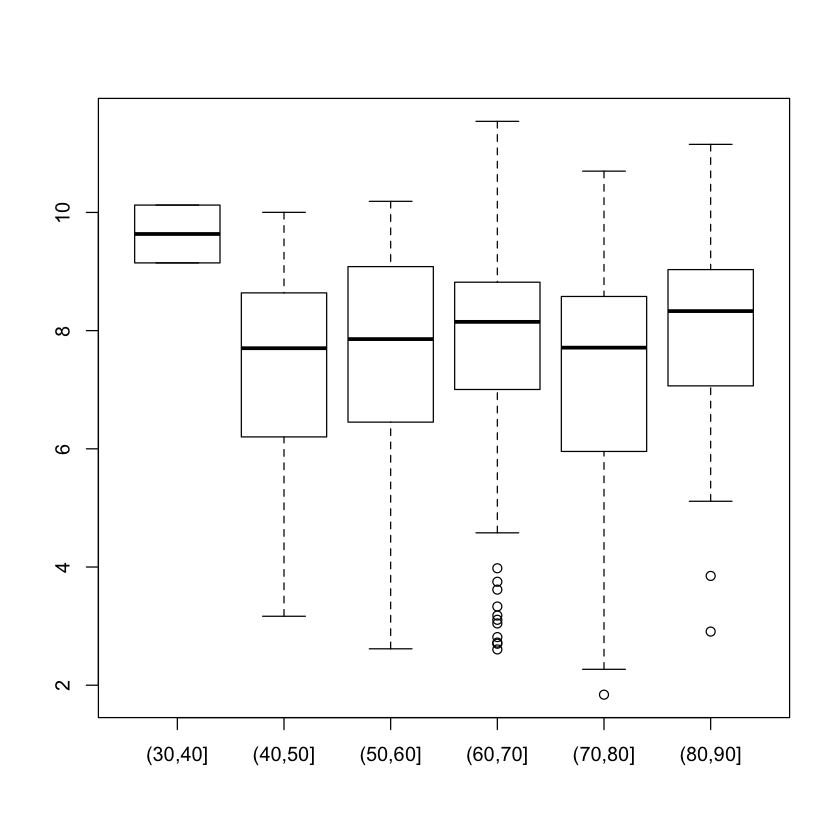

In [64]:
boxplot(split(log(ana(BLCArnan["FGFR3",])+1), cut(BLCArnan$age_at_initial_pathologic_diagnosis, seq(30,95,10))))

The assay data are retrieved using a SQL query constructed through the interaction of DelayedArray and bigrquery.

![SQL for FGFR3 retrieval](bq.png)

## Summary of BigQuery interface demonstration

This section describes how the SummarizedExperiment idioms can be used to work with the PanCancer Atlas data lodged in BigQuery.
The interface code reshapes the data after forming and executing the request, so that the rectangular structures
typical of SummarizedExperiment assay data can be manipulated without special code.  The reshaping
occurs in R at the user level.

The restfulSE package contains a test suite that compares results of "hand-written" SQL queries to the
equivalent SummarizedExperiment operations.  The queries are generated for randomly chosen samples and
features for both approaches, to help identify breaking changes in the underlying infrastructure, should such arise.